In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
#notebook
import copy
from realnvp.real_nvp_mlp import RealNVP_MLP

import os
import time
from datetime import date
import pickle

#from realnvp.phifour_utils import PhiFour, plot_2d_level
#from realnvp.gaussian_utils import MoG, plot_2d_level, plot_2d_level_reversed
from realnvp.real_nvp_mlp import RealNVP_MLP
from realnvp.sampling import estimate_deltaF
from realnvp.training import train
from realnvp.utils_io import get_file_name

# set up devices, seeds
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = "cpu" # just plotting here
dtype = torch.float32
torch.manual_seed(998213)
print("Running on device {}".format(device))

# initalize potential, find path end points
from realnvp.two_channel import TwoChannel
target = TwoChannel(device=device)
from realnvp.two_channel import get_bridge, bridge_energy


Running on device cpu


In [2]:
def nll(x, model, target):
    z, log_det_jac = model.backward(x)
    bridge_kwargs = model.prior_arg["bridge_kwargs"]
    a_min = torch.tensor([bridge_kwargs["x0"],bridge_kwargs["y0"]], device=device)
    b_min = torch.tensor([bridge_kwargs["x1"],bridge_kwargs["y1"]], device=device)
    nll = target.beta * bridge_energy(z, dt=target.dt, a_min=a_min, b_min=b_min, device=device)
    return nll - log_det_jac

def run_action_mh_langevin(model, target, x_init, n_steps, dt_path, bc=None):
    '''
    Path action langevin for diffusions
    model (nn.Module): model with the function `model.action(xt)` implemented
    xt (tensor): initial trajectory
    dt (float): integration timestep for the input trajectory
    drift (tensor): non-conservative forcing term with dimensions of x
    bc (float): None or PBC (hypercube) specified as bc=L for [0,L]^d
    '''
    xts = []
    accs = []
    betadt = target.beta
    xt = x_init.clone().detach_().requires_grad_()
    for t in range(n_steps):
        #with torch.no_grad():
        x = model.sample(xt.shape[0])
        xt = xt.reshape(-1, model.dim)

        ratio = -betadt * target.U(x) + nll(x, model, target)
        ratio += betadt * target.U(xt) - nll(xt, model, target)
        ratio = torch.exp(ratio)
        u = torch.rand_like(ratio)
        acc = u < torch.min(ratio, torch.ones_like(ratio))
        x[~acc] = xt[~acc]
        # xs.append(x.clone())
        accs.append(acc)
        xt.data = x.clone().detach()

        gradPath = torch.autograd.grad(target.U(xt).sum(), xt)[0]
        noise = np.sqrt(2 * dt_path / (betadt)) * \
            torch.randn_like(gradPath)
        xt = xt - gradPath * dt_path + noise
        if bc is not None:
            xt = xt +  bc * (xt < 0.) - bc * (xt > bc)
        xts.append(xt.clone())
    return torch.stack(xts), torch.stack(accs)

In [13]:
#for beta in [5,10]:
#    for nsteps in [100,150,200]:
import glob

def plot_run(beta, nsteps, date=date.today().isoformat(), chkpt=None, lr=5e-4, dt=6e-3, dtp=1e-5, base_dir=None, plot_name=None, save_plot_data=False):
    if base_dir is None:
        base_dir = "{:s}_lag_lr_{:e}_dt_{:e}_beta_{:02d}_nsteps_{:04d}_dtp_{:e}/".format(date,lr,dt,beta,nsteps,dtp)
        
    if chkpt is None:
        files = glob.glob(base_dir+"langevin*.pdf")
        chkpt = max([int(fname[-10:-4]) for fname in files])
        
    #args_target = torch.load(base_dir+"target_args.pkl", pickle_module=pickle, encoding="bytes") #, "rb") as f:
    with open(base_dir+"target_args.pkl", "rb") as f:
        args_target = pickle.load(f)
    print(args_target)
    target.beta = args_target["beta"]
    target.dt = args_target["dt"]
    target.n_steps = args_target["n_steps"]

    with open(base_dir+"rnvp_args.pkl", "rb") as f:
        args_rnvp = pickle.load(f)
    #args_rnvp = torch.load(base_dir+"rnvp_args.pkl", map_location=torch.device(device))
    print(args_rnvp)
    bridge_kwargs = args_rnvp["args_prior"]["bridge_kwargs"]

    generator = RealNVP_MLP(args_rnvp['dim'], args_rnvp['n_realnvp_block'],
                        args_rnvp['block_depth'], hidden_dim=args_rnvp['hidden_dim'], residual=True, rescale_t=True, 
                        init_weight_scale=args_rnvp['init_weight_scale'],
                        prior_arg=args_rnvp['args_prior'], device=device)

    state_dict_file = base_dir+"model_chkpt_{:06d}_nsteps_{:04d}.pkl".format(chkpt,args_target["n_steps"])
    generator.load_state_dict(torch.load(state_dict_file, map_location=torch.device(device)))

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
    n_bridges = 200



    n_steps = bridge_kwargs["n_steps"]
    #print(n_steps)
    bridges = torch.zeros(n_bridges,n_steps-2,1,2,device=device)
    for i in range(n_bridges):
        bridges[i,:] = get_bridge(**bridge_kwargs)

    # pushed_samples,_ = generator(bridges.view(n_bridges,-1))

    a_min = torch.tensor([bridge_kwargs["x0"],bridge_kwargs["y0"]])
    b_min = torch.tensor([bridge_kwargs["x1"],bridge_kwargs["y1"]])
    #print(bridge_energy(bridges,dt=target.dt,a_min=a_min,b_min=b_min,device=device))
    # print(target.U(pushed_samples))

    gen_samples = generator.sample(200)
    dt_path = dtp * target.beta * target.dt
    # metropolize
    xs, accs = run_action_mh_langevin(generator, target, gen_samples, 1, dt_path)
    xs_mh = xs[-1]

    target.plot(figax=(fig,axs[0,0]), colorbar=False)
    axs[0,0].set_title("Unmetropolized")
    for bridge in gen_samples.clone():
        b = bridge.view(-1,2)
        xs, ys = b.detach().cpu()[:,0],b.detach().cpu()[:,1]
        axs[0,0].plot(xs,ys,color="k", alpha=0.2)

    axs[0,1].set_title("Metropolized")
    target.plot(figax=(fig,axs[0,1]), colorbar=False)
    for bridge in xs_mh.clone():
        b = bridge.view(-1,2)
        xs, ys = b.detach().cpu()[:,0],b.detach().cpu()[:,1]
        if save_plot_data and plot_name is not None:
            np.save("{}_samples.npy".format(plot_name), b.detach().cpu().numpy())
        axs[0,1].plot(xs,ys,color="g", alpha=0.2)

    acc_data = np.loadtxt(base_dir+"accs.dat")
    loss_data = np.loadtxt(base_dir+"loss.dat")
    
    if save_plot_data and plot_name is not None:
        np.save("{}_accs.npy".format(plot_name), acc_data)
        np.save("{}_loss.npy".format(plot_name), loss_data)

    #fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axs[1,0].plot(loss_data)
    axs[1,0].set_ylabel("nll")
    axs[1,0].set_xlabel("training steps")



    axs[1,1].plot(acc_data)
    axs[1,1].set_ylabel("acceptance rate")
    axs[1,1].set_xlabel("training steps")

    fig.suptitle(r"$\beta={:f}, T={:f}, Checkpoint={:d}$".format(target.beta, target.n_steps*target.dt, chkpt))
    fig.tight_layout()
    if plot_name is None: 
        fig.savefig("samples_beta={:4.3f}_t={:4.3f}.pdf".format(target.beta, target.n_steps*target.dt))
    else:
        fig.savefig("{:s}.pdf".format(plot_name))

{'path_length': 98, 'dim': 2, 'beta': 4.0, 'dt': 0.006, 'n_steps': 100}
{'dim': 196, 'n_realnvp_block': 10, 'block_depth': 3, 'hidden_dim': 100, 'args_prior': {'type': 'bridge', 'bridge_kwargs': {'n_steps': 100, 'beta': 4.0, 'x0': tensor(-1., device='cuda:0'), 'x1': tensor(1., device='cuda:0'), 'y0': tensor(0., device='cuda:0'), 'y1': tensor(0., device='cuda:0'), 't0': 0.0, 't1': 0.6, 'dt': 0.006, 'device': 'cuda:0'}}, 'init_weight_scale': 1e-06}


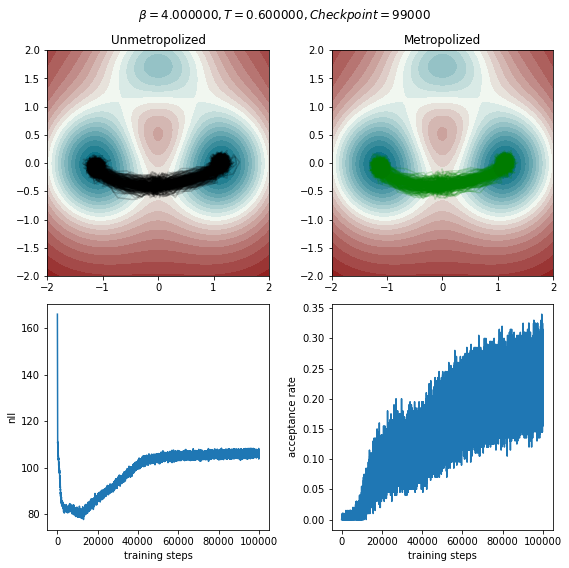

In [14]:
plot_run(4, 100, lr=5e-4, dt=6e-3, dtp=5e-5, date="2021-05-15", plot_name="beta=4.0_t=0.600_resampled", save_plot_data=True)

{'path_length': 98, 'dim': 2, 'beta': 4.0, 'dt': 0.006, 'n_steps': 100}
{'dim': 196, 'n_realnvp_block': 10, 'block_depth': 3, 'hidden_dim': 100, 'args_prior': {'type': 'bridge', 'bridge_kwargs': {'n_steps': 100, 'beta': 4.0, 'x0': tensor(-1., device='cuda:0'), 'x1': tensor(1., device='cuda:0'), 'y0': tensor(0., device='cuda:0'), 'y1': tensor(0., device='cuda:0'), 't0': 0.0, 't1': 0.6, 'dt': 0.006, 'device': 'cuda:0'}}, 'init_weight_scale': 1e-06}


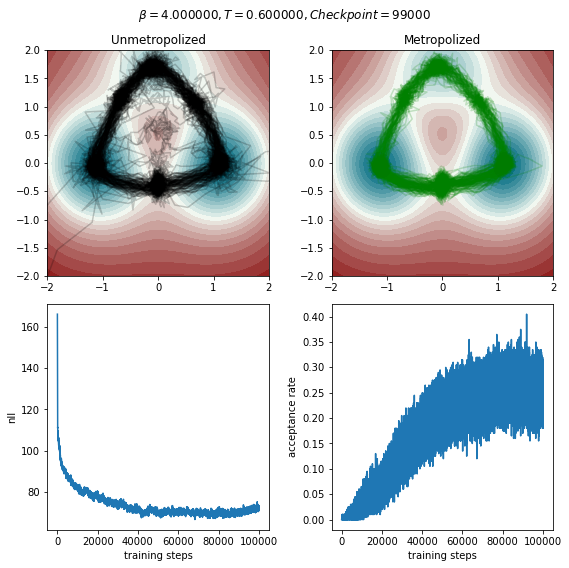

In [15]:
plot_run(4, 100, lr=5e-4, dt=6e-3, dtp=5e-5, date="2021-05-16", base_dir="2021-05-17_noresample_lr_5.000000e-04_dt_6.000000e-03_beta_04_nsteps_0100_dtp_5.000000e-05/", plot_name="beta=4.0_t=0.600_no_resampling", save_plot_data=True)

In [1]:
def plot_accs(beta, nsteps, date=date.today().isoformat(), chkpt=None, lr=5e-4, dt=6e-3, dtp=1e-5, base_dir=None, plot_name=None):
    if base_dir is None:
        #base_dir = "{:s}_lag_lr_1e-3_dt_{:e}_beta_{:02d}_nsteps_{:04d}_dtp_{:e}/".format(date,dt,beta,nsteps,dtp)
        base_dir = "{:s}_lag_lr_{:e}_dt_{:e}_beta_{:02d}_nsteps_{:04d}_dtp_{:e}/".format(date,lr,dt,beta,nsteps,dtp)

        
    if chkpt is None:
        files = glob.glob(base_dir+"langevin*.pdf")
        chkpt = max([int(fname[-10:-4]) for fname in files])
        
    #args_target = torch.load(base_dir+"target_args.pkl", pickle_module=pickle, encoding="bytes") #, "rb") as f:
    with open(base_dir+"target_args.pkl", "rb") as f:
        args_target = pickle.load(f)
    print(args_target)
    target.beta = args_target["beta"]
    target.dt = args_target["dt"]
    target.n_steps = args_target["n_steps"]

    with open(base_dir+"rnvp_args.pkl", "rb") as f:
        args_rnvp = pickle.load(f)
    #args_rnvp = torch.load(base_dir+"rnvp_args.pkl", map_location=torch.device(device))
    print(args_rnvp)
    bridge_kwargs = args_rnvp["args_prior"]["bridge_kwargs"]

    generator = RealNVP_MLP(args_rnvp['dim'], args_rnvp['n_realnvp_block'],
                        args_rnvp['block_depth'], hidden_dim=args_rnvp['hidden_dim'], residual=True, rescale_t=True, 
                        init_weight_scale=args_rnvp['init_weight_scale'],
                        prior_arg=args_rnvp['args_prior'], device=device)

    state_dict_file = base_dir+"model_chkpt_{:06d}_nsteps_{:04d}.pkl".format(chkpt,args_target["n_steps"])
    generator.load_state_dict(torch.load(state_dict_file, map_location=torch.device(device)))

    #fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,8))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

    n_bridges = 1000



    n_steps = bridge_kwargs["n_steps"]
    #print(n_steps)
    bridges = torch.zeros(n_bridges,n_steps-2,1,2,device=device)
    for i in range(n_bridges):
        bridges[i,:] = get_bridge(**bridge_kwargs)

    # pushed_samples,_ = generator(bridges.view(n_bridges,-1))

    a_min = torch.tensor([bridge_kwargs["x0"],bridge_kwargs["y0"]])
    b_min = torch.tensor([bridge_kwargs["x1"],bridge_kwargs["y1"]])
    #print(bridge_energy(bridges,dt=target.dt,a_min=a_min,b_min=b_min,device=device))
    # print(target.U(pushed_samples))

    gen_samples = generator.sample(1000)
    dt_path = dtp * target.beta * target.dt
    # metropolize
    xs, accs = run_action_mh_langevin(generator, target, gen_samples, 10, dt_path)
    xs_mh = xs[-1]

#     target.plot(figax=(fig,axs[0,0]), colorbar=False)
#     axs[0,0].set_title("Unmetropolized")
#     for bridge in gen_samples.clone():
#         b = bridge.view(-1,2)
#         xs, ys = b.detach().cpu()[:,0],b.detach().cpu()[:,1]
#         axs[0,0].plot(xs,ys,color="k", alpha=0.2)

    col = "#175E54"

    axs[0].set_title("Sampled transition paths")
    target.plot(figax=(fig,axs[0]), colorbar=False)
    for bridge in xs_mh.clone():
        b = bridge.view(-1,2)
        xs, ys = b.detach().cpu()[:,0],b.detach().cpu()[:,1]
        axs[0].plot(xs,ys,color=col, alpha=0.1)

    acc_data = np.loadtxt(base_dir+"accs.dat")
    #loss_data = np.loadtxt(base_dir+"loss.dat")

    #fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
#     axs[1,0].plot(loss_data)
#     axs[1,0].set_ylabel("nll")
#     axs[1,0].set_xlabel("training steps")



    axs[1].plot(acc_data,c=col)
    axs[1].set_ylabel("acceptance rate")
    axs[1].set_xlabel("training steps")
    

    #axs[0].annotate('(a)', xy=(0.01,0.95), xycoords='figure fraction')
    #axs[1].annotate('(b)', xy=(0.01,0.475), xycoords='figure fraction')
    
    axs[0].annotate('(a)', xy=(0.01, 0.95), xycoords='figure fraction')
    axs[1].annotate('(b)', xy=(0.95, 0.95), xycoords='figure fraction')

    #fig.suptitle(r"Sampling Augmented with Normalizing Flow")
    fig.tight_layout()
    if plot_name is None: 
        fig.savefig("sampling_fig.pdf".format(target.beta, target.n_steps*target.dt))
    else:
        fig.savefig("{:s}.pdf".format(plot_name))

NameError: name 'date' is not defined

{'path_length': 98, 'dim': 2, 'beta': 4.0, 'dt': 0.006, 'n_steps': 100}
{'dim': 196, 'n_realnvp_block': 10, 'block_depth': 3, 'hidden_dim': 100, 'args_prior': {'type': 'bridge', 'bridge_kwargs': {'n_steps': 100, 'beta': 4.0, 'x0': tensor(-1., device='cuda:0'), 'x1': tensor(1., device='cuda:0'), 'y0': tensor(0., device='cuda:0'), 'y1': tensor(0., device='cuda:0'), 't0': 0.0, 't1': 0.6, 'dt': 0.006, 'device': 'cuda:0'}}, 'init_weight_scale': 1e-06}


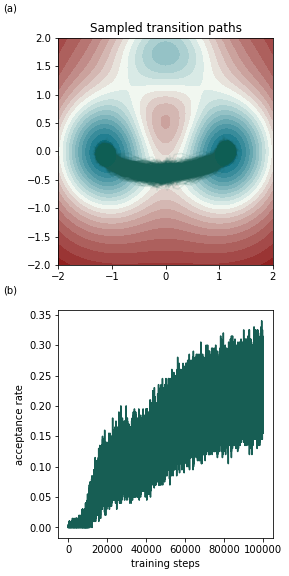

In [64]:
plot_accs(4, 100, dt=6e-3, dtp=5e-5, date="2021-05-15", plot_name="tps_resampling")

{'path_length': 98, 'dim': 2, 'beta': 4.0, 'dt': 0.006, 'n_steps': 100}
{'dim': 196, 'n_realnvp_block': 10, 'block_depth': 3, 'hidden_dim': 100, 'args_prior': {'type': 'bridge', 'bridge_kwargs': {'n_steps': 100, 'beta': 4.0, 'x0': tensor(-1., device='cuda:0'), 'x1': tensor(1., device='cuda:0'), 'y0': tensor(0., device='cuda:0'), 'y1': tensor(0., device='cuda:0'), 't0': 0.0, 't1': 0.6, 'dt': 0.006, 'device': 'cuda:0'}}, 'init_weight_scale': 1e-06}


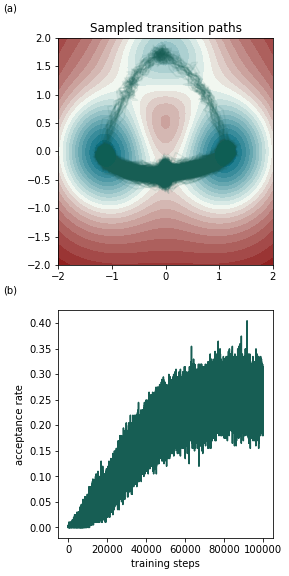

In [65]:
plot_accs(4, 100, dt=6e-3, dtp=5e-5, date="2021-05-16", base_dir="2021-05-17_noresample_lr_5.000000e-04_dt_6.000000e-03_beta_04_nsteps_0100_dtp_5.000000e-05/", plot_name="tps_no_resampling")